# Training file for any model

## Imports

In [1]:
import platform 


device = None
if platform.system() == 'Windows':  # Check if the OS is Windows
    import torch_directml  # Import torch_directml only on Windows
    device = torch_directml.device()
else:
    !pip install -r requirements.txt
    pass


In [2]:
from src.models.Trainer import Trainer
from src.dataset.ImageDatasetPatch import ImageDatasetPatch
from src.dataset.PatchImageTool import PatchImageTool

from src.utils.PytorchUtil import PytorchUtil as torchUtil
from src.utils.PlotUtils import PlotUtils

from src.models.StatsManager import StatsManager

from src.models.InitModel import InitModel

import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import skimage.metrics as metrics
# Import the platform module to detect the OS

if not device:
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.cuda.empty_cache()
    else:
        device = torch.device('cpu')

print(device)

2024-01-22 11:45:33.725848: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-22 11:45:33.725877: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-22 11:45:33.726691: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-22 11:45:33.731800: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-22 11:45:34.489871: W tensorflow/compiler/tf2

cuda


## Training information

In [3]:
SUBSET_SIZE = 5000 #10000

LR = 0.0005
BATCH_SIZE = 20
PATCH_SIZE = 256

UPSCALE_FACTORS = [2, 4, 8]

TRAIN_SET = "train_full_channel"
TEST_SET =  "test_full_channel"

IMAGE_DIM = "1920x1080"

CHANNELS = ["b", "g", "r", "d", "s"]

SEED = None#42

# ------------------------------------------

SMALL_DATASET_RANDOM_PATCH = False
SMALL_DATASET_NUM_PATCH = 16

PATH_SAVE_SMALL_MODEL = "smallweights-upscale-residual2-lpips-v.4.1"
SMALL_MODEL_USE_LPIPS = "lpips" in PATH_SAVE_SMALL_MODEL

EPOCH_SMALL_MODEL = 50

DO_OVERFIT_MODEL = True

# ------------------------------------------

PATH_SAVE_MODEL = "weights-upscale-residual2-lpips-v.4.1"
MODEL_USE_LPIPS = "lpips" in PATH_SAVE_MODEL

EPOCH_MODEL = 50

## Utility function

In [4]:
if SEED:
    torch.manual_seed(SEED)
    np.random.seed(SEED)

In [5]:
class SuperResolutionStatsManager(StatsManager):
    def __init__(self, upscaling_factor):
        super(SuperResolutionStatsManager, self).__init__(upscaling_factor)

    def init(self):
        super(SuperResolutionStatsManager, self).init()
        # Initializing `self.running_psnr`
        self.metrics = ['psnr', 'ssim']

        self.running_metrics = {}
        for upscaling_factor in self.upscale_factor_list:
            self.running_metrics[upscaling_factor] = {}

            for metric in self.metrics:
                self.running_metrics[upscaling_factor][metric] = 0

    def accumulate(self, loss, x, y, d, upscale_factor):
        super(SuperResolutionStatsManager, self).accumulate(loss, x, y, d, upscale_factor)
        # Updating `self.running_psnr`
        d_numpy = d.detach().to('cpu').numpy()
        y_numpy = y.detach().to('cpu').numpy()

        self.running_metrics[upscale_factor]["psnr"] += metrics.peak_signal_noise_ratio(d_numpy, y_numpy)

        current_ssim = 0

        for i in range(d_numpy.shape[0]):
            d_numpy_temp = np.moveaxis(d_numpy[i], [0, 1, 2], [2, 0, 1])
            y_numpy_temp = np.moveaxis(y_numpy[i], [0, 1, 2], [2, 0, 1])

            value_range = max(d_numpy_temp.max(), y_numpy_temp.max()) - min(d_numpy_temp.min(), y_numpy_temp.min())
            
            current_ssim += metrics.structural_similarity(d_numpy_temp, y_numpy_temp, win_size=7, 
                                                          data_range=value_range, multichannel=True, 
                                                          channel_axis=2)
        
        self.running_metrics[upscale_factor]["ssim"] += current_ssim / d_numpy.shape[0]

    def summarize(self):
        losses : dict = super(SuperResolutionStatsManager, self).summarize()
    
        result = {}
        for upscale_factor in self.upscale_factor_list:
            result[upscale_factor] = {
                "loss" : {},
                "metric" : {}
            }

            # value / (self.number_update + 1e-9)
            for key in self.metrics:
                result[upscale_factor]["metric"][key] = self.running_metrics[upscale_factor][key] \
                                    / (self.number_update[upscale_factor] + 1e-9)
            
            for key in losses[upscale_factor].keys():
                result[upscale_factor]["loss"][key] = losses[upscale_factor][key]

        return result


class Criterion:
    def __init__(self, use_lpips=False) -> None:
        self.use_lpips = use_lpips

    def compute(self, y, d, lpips, lpips_lambda):
        mse = F.mse_loss(y, d)
        
        if not self.use_lpips:
            return {
                "loss" : mse,
                "mse" : mse,
            }

        lpips = lpips(y, d) * lpips_lambda
        
        return {
            "loss" : mse + lpips,
            "mse" : mse,
            "lpips" : lpips
        }

    def itemize(self, loss):
        cop = {}

        for key in loss.keys():
            if type(loss[key]) == torch.Tensor:
                cop[key] = loss[key].item()
            else:
                cop[key] = loss[key]
        
        return cop

    """
    Return only the sum loss
    """
    def __call__(self, y, d, lpips, lpips_lambda):
        return self.compute(y, d, lpips, lpips_lambda)["loss"]

## Data loader

In [6]:
new_img_size = 256
common_transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

train_transform = transforms.Compose([
    common_transform,
    #transforms.RandomRotation(degrees=10),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    #transforms.RandomResizedCrop(size=(new_img_size, new_img_size), scale=(0.8, 1.0), ratio=(0.75, 1.333)),
])

valid_transform = transforms.Compose([
    common_transform,
    #transforms.CenterCrop((new_img_size, new_img_size)),
])

In [7]:
full_train_dataset = ImageDatasetPatch(TRAIN_SET, IMAGE_DIM, UPSCALE_FACTORS, CHANNELS,
                                        transforms=train_transform, download=True, patch_size=PATCH_SIZE)

full_test_dataset = ImageDatasetPatch(TEST_SET, IMAGE_DIM, UPSCALE_FACTORS, CHANNELS,
                                      transforms=train_transform, download=True, patch_size=PATCH_SIZE)

train_dataset_patched = ImageDatasetPatch(TRAIN_SET, IMAGE_DIM, UPSCALE_FACTORS, CHANNELS,
                                          transforms=train_transform, download=True, patch_size=PATCH_SIZE)
test_dataset_patched = ImageDatasetPatch(TEST_SET, IMAGE_DIM, UPSCALE_FACTORS, CHANNELS,
                                          transforms=train_transform, download=True, patch_size=PATCH_SIZE)

full_train_dataset.print_info()

Check for download and resize ...
Check for download and resize ...
Check for download and resize ...
Check for download and resize ...
Number of train high (1920x1080) resolution images: 183
Number of train low (960x540) resolution images: 183
Number of train low (480x270) resolution images: 183
Number of train low (240x135) resolution images: 183


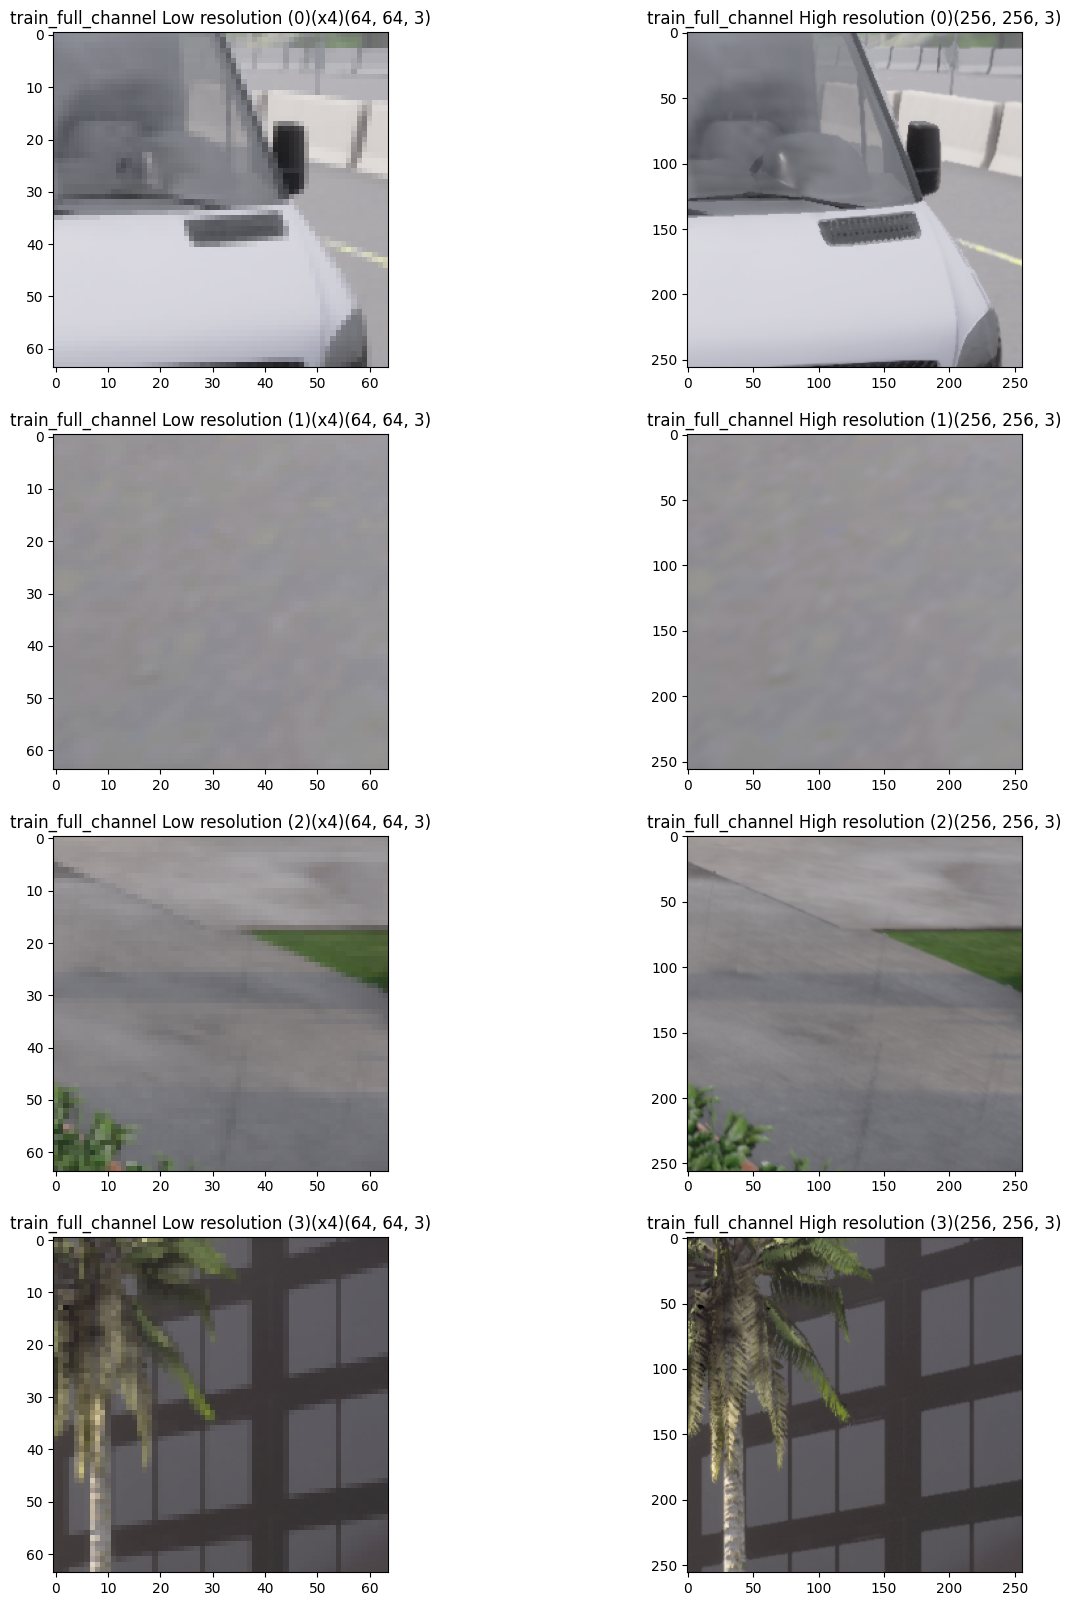

In [8]:
PlotUtils.show_dataset_example(full_train_dataset, num_images=4, plot_width=15)

In [9]:
"""
redirect all method of list to dataset
"""
class EncapsulatedDataset(list):
    def __init__(self, dataset, upscale_factors, filter_channel_to_image_func):
        self.dataset = dataset
        self.upscale_factors = upscale_factors
        self.filter_channel_to_image_func = filter_channel_to_image_func

        self.channel = CHANNELS

    def number_upscale(self):
        return len(self.upscale_factors)

    def get_upscale_factor(self, index):
        return self.upscale_factors[index]
    
    def filter_channels_to_image(self, channel):
        return self.filter_channel_to_image_func(channel)

    def __len__(self):
        return self.dataset.__len__()
    
    def __getitem__(self, index):
        return self.dataset.__getitem__(index)
    
    def __iter__(self):
        return self.dataset.__iter__()
    
    def __next__(self):
        return self.dataset.__next__()
    
    def __str__(self):
        return self.dataset.__str__()
    
    def __repr__(self):
        return self.dataset.__repr__()
    
    def __contains__(self, item):
        return self.dataset.__contains__(item)
    
    def __reversed__(self):
        return self.dataset.__reversed__()
    
    def __add__(self, other):
        return self.dataset.__add__(other)

## Training a model on a small dataset 

In [10]:
if DO_OVERFIT_MODEL:
    if SMALL_DATASET_RANDOM_PATCH:
        small_dataset = [train_dataset_patched[np.random.randint(len(train_dataset_patched))] for _ in range(SMALL_DATASET_NUM_PATCH)]
    else:
        small_dataset = [train_dataset_patched[i] for i in range(SMALL_DATASET_NUM_PATCH)]

    small_train_size = int(0.8 * len(small_dataset))
    small_valid_size = len(small_dataset) - small_train_size

    # no random split
    if SMALL_DATASET_RANDOM_PATCH:
        small_train_dataset, small_valid_dataset = torchUtil.random_split(small_dataset, [small_train_size, small_valid_size])
    else:
        small_train_dataset = small_dataset[:small_train_size]
        small_valid_dataset = small_dataset[small_train_size:]

    small_train_dataset = EncapsulatedDataset(small_train_dataset, UPSCALE_FACTORS, train_dataset_patched.filter_channels_to_image)
    small_valid_dataset = EncapsulatedDataset(small_valid_dataset, UPSCALE_FACTORS, test_dataset_patched.filter_channels_to_image)

    print("Size of small_train_dataset:", len(small_train_dataset))

Size of small_train_dataset: 12


In [11]:
if DO_OVERFIT_MODEL:
      torch.cuda.empty_cache()

      model_hyperparameters = {
      "channel_positions" : CHANNELS,
      "channel_interpolations" : [train_dataset_patched.get_channel_superresolution_method(channel) for channel in CHANNELS]
      }
      
      r_small = InitModel.create_model(PATH_SAVE_SMALL_MODEL, model_hyperparameters, UPSCALE_FACTORS, device)

      # In mega bytes
      print("Size of model mb", sum(p.numel() for p in r_small.parameters() if p.requires_grad) / (1024 * 1024))

      # Size of batch in mega bytes
      #print("Size of batch mb", small_dataset[0][0].shape[0] * small_dataset[0][0].shape[1] 
            #* small_dataset[0][0].shape[2] * 4 / (1024 * 1024))

      adam = torch.optim.Adam(r_small.parameters(), lr=LR)
      stats_manager = SuperResolutionStatsManager(UPSCALE_FACTORS)

      exp_small = Trainer(r_small, 
                        small_train_dataset, small_valid_dataset, 
                        adam, stats_manager, device, 
                        Criterion(use_lpips=SMALL_MODEL_USE_LPIPS)
                        , batch_size=2,
                        output_dir=PATH_SAVE_SMALL_MODEL, perform_validation_during_training=True, 
                        tensor_board=False, use_lpips_loss=SMALL_MODEL_USE_LPIPS)

      # Show number of parameters
      print("Number of parameters:", sum(p.numel() for p in r_small.parameters() if p.requires_grad))

Size of model mb 0.4606809616088867
Number of parameters: 483059


In [12]:
if DO_OVERFIT_MODEL:
    exp_small.run(num_epochs=EPOCH_SMALL_MODEL, plot=PlotUtils.plot_training_curve_and_metric)

Start/Continue training from epoch 0
Epoch 1 (Time : 2.66s) 
	 trai.. x2 =>loss : 0.011 | mse : 0.01 | lpips : 0.0011 | psnr : 21.47 ssim : 0.75 
	 trai.. x4 =>loss : 0.0093 | mse : 0.008 | lpips : 0.0012 | psnr : 21.98 ssim : 0.73 
	 trai.. x8 =>loss : 0.0091 | mse : 0.0077 | lpips : 0.0014 | psnr : 21.88 ssim : 0.67 
	 vali.. x2 =>loss : 0.003 | mse : 0.0022 | lpips : 0.0008 | psnr : 27.27 ssim : 0.62 
	 vali.. x4 =>loss : 0.0036 | mse : 0.0025 | lpips : 0.0011 | psnr : 26.81 ssim : 0.55 
	 vali.. x8 =>loss : 0.0045 | mse : 0.003 | lpips : 0.0015 | psnr : 26.14 ssim : 0.48 
Epoch 2 (Time : 1.85s) 
	 trai.. x2 =>loss : 0.0016 | mse : 0.0011 | lpips : 0.0004 | psnr : 30.6 ssim : 0.89 
	 trai.. x4 =>loss : 0.0022 | mse : 0.0015 | lpips : 0.0007 | psnr : 28.91 ssim : 0.83 
	 trai.. x8 =>loss : 0.0035 | mse : 0.0025 | lpips : 0.001 | psnr : 26.44 ssim : 0.73 
	 vali.. x2 =>loss : 0.0011 | mse : 0.0005 | lpips : 0.0006 | psnr : 33.16 ssim : 0.72 
	 vali.. x4 =>loss : 0.0017 | mse : 0.0008 

In [ ]:
if DO_OVERFIT_MODEL:
    PlotUtils.plot_images_from_model(exp_small, small_train_dataset, device, indices=[0, 1, 2])

In [ ]:
if DO_OVERFIT_MODEL:
    PlotUtils.plot_predicted_and_bicubic(exp_small, small_train_dataset, device, indices=[0, 1, 2])

# Training a model on a subsequent part of the original dataset

In [ ]:
# Limit the dataset size
if len(train_dataset_patched) > SUBSET_SIZE:
    train_dataset_patched.limit_dataset(SUBSET_SIZE)

if len(test_dataset_patched) > SUBSET_SIZE * 0.2:
    test_dataset_patched.limit_dataset(int(SUBSET_SIZE * 0.2))

print("Size of sub train dataset", len(train_dataset_patched))
print("Size of sub test dataset", len(test_dataset_patched))

Size of sub train dataset 5000
Size of sub test dataset 1000


In [ ]:
# Take the sub part of the dataset from random indices
train_size = int(0.8 * len(train_dataset_patched))
valid_size = len(train_dataset_patched) - train_size

train_sub_dataset, valid_sub_dataset = torch.utils.data.random_split(train_dataset_patched, [train_size, valid_size])

train_sub_dataset = EncapsulatedDataset(train_sub_dataset, UPSCALE_FACTORS, train_dataset_patched.filter_channels_to_image)
valid_sub_dataset = EncapsulatedDataset(valid_sub_dataset, UPSCALE_FACTORS, test_dataset_patched.filter_channels_to_image)

print("Size of train_dataset: ", len(train_sub_dataset))
print("Size of valid_dataset: ", len(valid_sub_dataset))

Size of train_dataset:  4000
Size of valid_dataset:  1000


In [ ]:
torch.cuda.empty_cache()

model_hyperparameters = {
    "channel_positions" : CHANNELS,
    "channel_interpolations" : [train_dataset_patched.get_channel_superresolution_method(channel) for channel in CHANNELS]
}

r = InitModel.create_model(PATH_SAVE_MODEL, model_hyperparameters, UPSCALE_FACTORS, device)

# number of parameters
print("Number of parameters:", sum(p.numel() for p in r.parameters() if p.requires_grad))

adam = torch.optim.Adam(r.parameters(), lr=LR)
stats_manager = SuperResolutionStatsManager(UPSCALE_FACTORS)

exp = Trainer(r, 
                train_sub_dataset, valid_sub_dataset, 
                adam, stats_manager, device, 
                Criterion(use_lpips=MODEL_USE_LPIPS), 
                batch_size=BATCH_SIZE,
                output_dir=PATH_SAVE_MODEL, perform_validation_during_training=True, 
                tensor_board=True, use_lpips_loss=MODEL_USE_LPIPS)

Number of parameters: 483059
dict_keys(['state', 'param_groups'])
dict_keys(['state', 'param_groups'])


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
exp.run(num_epochs=EPOCH_MODEL, plot=PlotUtils.plot_training_curve_and_metric)

In [ ]:
PlotUtils.plot_images_from_model(exp, train_dataset_patched, device, indices=[0, 1, 2])

In [ ]:
PlotUtils.plot_predicted_and_bicubic(exp, train_dataset_patched, device, indices=[0, 1, 2])

# Reconstruct image from patch

In [ ]:
train_patch_index = np.random.randint(len(full_train_dataset))
test_patch_index = np.random.randint(len(full_test_dataset))

print("Choose index train", train_patch_index, "Choose index test", test_patch_index)

train_patch_start_index = full_train_dataset.get_index_start_patch(train_patch_index)
test_patch_start_index = full_test_dataset.get_index_start_patch(test_patch_index)

print ("Start index patch train", train_patch_start_index, "Start index patch test", test_patch_start_index)

train_image_index = full_train_dataset.get_index_for_image(train_patch_index)
test_image_index = full_test_dataset.get_index_for_image(test_patch_index)

print ("Index train", train_image_index, "Index test", test_image_index)

IMAGE_CHOSEN_UPSCALE_INDEX = 0

train_lr_data_tensors, train_hr_img_tensor = full_train_dataset.get_full_image(train_image_index)
test_lr_data_tensors, test_hr_img_tensor = full_test_dataset.get_full_image(test_image_index)

train_lr_data_tensor = train_lr_data_tensors[IMAGE_CHOSEN_UPSCALE_INDEX]
train_lr_img_tensor = full_train_dataset.filter_channels_to_image(train_lr_data_tensor)

test_lr_data_tensor = test_lr_data_tensors[IMAGE_CHOSEN_UPSCALE_INDEX]
test_lr_img_tensor = full_test_dataset.filter_channels_to_image(test_lr_data_tensor)

hr_img_tensors = full_train_dataset.hr_data_size

exp.net.set_upscale_mode(full_test_dataset.get_upscale_factor(IMAGE_CHOSEN_UPSCALE_INDEX))

train_pred_img_tensor = PatchImageTool.predict_image_from_dataset_patches(exp, hr_img_tensors, full_train_dataset, train_patch_index, device)
test_pred_img_tensor = PatchImageTool.predict_image_from_dataset_patches(exp, hr_img_tensors, full_test_dataset, test_patch_index, device)

In [ ]:
PlotUtils.show_low_high_predicted([train_lr_img_tensor], [train_hr_img_tensor], [train_pred_img_tensor], plot_title="Train")

PlotUtils.show_low_high_predicted([test_lr_img_tensor], [test_hr_img_tensor], [test_pred_img_tensor], plot_title="Test")

In [ ]:
train_pred_img_np = torchUtil.tensor_to_numpy(train_pred_img_tensor)
train_bicubic_img_np = torchUtil.resize_tensor_to_numpy(train_lr_img_tensor, 
                                                        (train_pred_img_np.shape[0], train_pred_img_np.shape[1]))

train_subtraction_np = torchUtil.norm_numpy_image(train_pred_img_np - train_bicubic_img_np)

PlotUtils.show_predicted_interpolated_subtraction([train_pred_img_np], [train_bicubic_img_np], [train_subtraction_np], 
                                                  plot_title="Train")


test_pred_img_np = torchUtil.tensor_to_numpy(test_pred_img_tensor)

test_bicubic_img_np = torchUtil.resize_tensor_to_numpy(test_lr_img_tensor, 
                                                         (test_pred_img_np.shape[0], test_pred_img_np.shape[1]))


test_subtraction_np = torchUtil.norm_numpy_image(test_pred_img_np - test_bicubic_img_np)

PlotUtils.show_predicted_interpolated_subtraction([test_pred_img_np], [test_bicubic_img_np], [test_subtraction_np],
                                                   plot_title="Test")


In [ ]:
# Compute the PSNR and SSIM for the predicted image

train_hr_img_np = torchUtil.tensor_to_numpy(train_hr_img_tensor)
train_pred_img_np = torchUtil.tensor_to_numpy(train_pred_img_tensor)

train_psnr = metrics.peak_signal_noise_ratio(train_hr_img_np, train_pred_img_np)
train_ssim = metrics.structural_similarity(train_hr_img_np, train_pred_img_np,
                                            win_size=7, data_range=1, multichannel=True, channel_axis=2)

test_hr_img_np = torchUtil.tensor_to_numpy(test_hr_img_tensor)
test_pred_img_np = torchUtil.tensor_to_numpy(test_pred_img_tensor)

test_psnr = metrics.peak_signal_noise_ratio(test_hr_img_np, test_pred_img_np)
test_ssim = metrics.structural_similarity(test_hr_img_np, test_pred_img_np, 
                                          win_size=7, data_range=1, multichannel=True, channel_axis=2)

print("Train PSNR", train_psnr, "Train SSIM", train_ssim)
print("Test PSNR", test_psnr, "Test SSIM", test_ssim)

# Compute the PSNR and SSIM for the bilinear image

train_bicubic_psnr = metrics.peak_signal_noise_ratio(train_hr_img_np, train_bicubic_img_np)
train_bicubic_ssim = metrics.structural_similarity(train_hr_img_np, train_bicubic_img_np, win_size=7, 
                                                   data_range=1, multichannel=True, channel_axis=2)

test_bicubic_psnr = metrics.peak_signal_noise_ratio(test_hr_img_np, test_bicubic_img_np)
test_bicubic_ssim = metrics.structural_similarity(test_hr_img_np, test_bicubic_img_np, win_size=7,
                                                   data_range=1, multichannel=True, channel_axis=2)

print()
print("Train bicubic PSNR", train_bicubic_psnr, "Train bicubic SSIM", train_bicubic_ssim)
print("Test bicubic PSNR", test_bicubic_psnr, "Test bicubic SSIM", test_bicubic_ssim)

In [ ]:
# Test on 20 images from the test set
sub_dataset_size = 20
indices = np.random.choice(len(full_test_dataset), sub_dataset_size, replace=False)
pred_img_tensors = PatchImageTool.predict_images_from_dataset_patches(exp, (1920, 1080), full_test_dataset, indices, device, 
                                                                      batch_size=BATCH_SIZE)

In [ ]:
# Show 4 images, real vs predicted

lr_img_tensors = []
hr_img_tensors = []

for i in range(4):
    index = indices[i]
    image_index = full_test_dataset.get_index_for_image(index)

    lr_data_tensors, hr_img_tensor = full_test_dataset.get_full_image(image_index)
    lr_data_tensor = lr_data_tensors[IMAGE_CHOSEN_UPSCALE_INDEX]

    lr_img_tensors.append(train_dataset_patched.filter_channels_to_image(lr_data_tensor))
    hr_img_tensors.append(hr_img_tensor)

PlotUtils.show_low_high_predicted(lr_img_tensors, hr_img_tensors, pred_img_tensors[:len(lr_img_tensors)], plot_title="Test")

In [ ]:
# Show 4 images, predicted, bilinear and subtraction

pred_img_nps = []
bicubic_img_nps = []
subtraction_img_nps = []

for i in range(4):
    index = indices[i]
    image_index = full_test_dataset.get_index_for_image(index)

    lr_data_tensors, hr_img_tensor = full_test_dataset.get_full_image(image_index)
    lr_data_tensor = lr_data_tensors[IMAGE_CHOSEN_UPSCALE_INDEX]

    lr_img_tensor = train_dataset_patched.filter_channels_to_image(lr_data_tensor)

    pred_img_np = torchUtil.tensor_to_numpy(pred_img_tensors[i])
    bicubic_img_np = torchUtil.resize_tensor_to_numpy(lr_img_tensor, (pred_img_np.shape[0], pred_img_np.shape[1]))

    pred_img_nps.append(pred_img_np)
    bicubic_img_nps.append(bicubic_img_np)
    
    subtraction_img_np = torchUtil.norm_numpy_image(pred_img_np - bicubic_img_np)
    subtraction_img_nps.append(subtraction_img_np)

PlotUtils.show_predicted_interpolated_subtraction(pred_img_nps, bicubic_img_nps, subtraction_img_nps, 
                                                  plot_title="Test")

In [ ]:
# compute the mean and var psnr and ssim for n images from the test set

batch_size = full_test_dataset.get_number_patch_per_image(upscale_index=IMAGE_CHOSEN_UPSCALE_INDEX) * 4

sub_size_factor = 1
sub_dataset_size = int(sub_size_factor * len(full_test_dataset) / full_test_dataset.get_number_patch_per_image(upscale_index=IMAGE_CHOSEN_UPSCALE_INDEX))
print("Number of images in full data set part", sub_dataset_size)
test_psnr, test_ssim = PatchImageTool.compute_metrics_dataset_batched(exp, (1920, 1080), full_test_dataset, sub_dataset_size, device, batch_size)

# Compute the PSNR and SSIM for the bilinear image on a subset of the train set

test_bicubic_psnr, test_bicubic_ssim = [], []

for i in range(sub_dataset_size):
    lr_data_tensors, hr_img_tensor = full_test_dataset.get_full_image(i)

    lr_data_tensor = lr_data_tensors[IMAGE_CHOSEN_UPSCALE_INDEX]
    lr_img_tensor = full_test_dataset.filter_channels_to_image(lr_data_tensor)

    hr_img_np = torchUtil.tensor_to_numpy(hr_img_tensor)

    bicubic_img_np = torchUtil.resize_tensor_to_numpy(lr_img_tensor, (hr_img_np.shape[0], hr_img_np.shape[1]))

    test_bicubic_psnr.append(metrics.peak_signal_noise_ratio(hr_img_np, bicubic_img_np))
    test_bicubic_ssim.append(metrics.structural_similarity(hr_img_np, bicubic_img_np, 
                                                            win_size=7, data_range=1,
                                                            multichannel=True, channel_axis=2))

# compute the mean and var psnr and ssim for 100 images from the train set

print("Average PSNR for test images", test_psnr.mean(), "Variance", test_psnr.var())
print("Average SSIM for test images", test_ssim.mean(), "Variance", test_ssim.var())

print("Average PSNR for bicubic test images", np.array(test_bicubic_psnr).mean(), "Variance", np.array(test_bicubic_psnr).var())
print("Average SSIM for bicubic test images", np.array(test_bicubic_ssim).mean(), "Variance", np.array(test_bicubic_ssim).var())

print()

sub_dataset_size = int(sub_size_factor * len(full_train_dataset) / full_train_dataset.get_number_patch_per_image(upscale_index=IMAGE_CHOSEN_UPSCALE_INDEX))
print("Number of images in full data set part", sub_dataset_size)
train_psnr, train_ssim = PatchImageTool.compute_metrics_dataset_batched(exp,  (1920, 1080), 
                                                                        full_train_dataset, sub_dataset_size, device, batch_size)

train_bicubic_psnr, train_bicubic_ssim = [], []

for i in range(sub_dataset_size):
    lr_data_tensors, hr_img_tensor = full_train_dataset.get_full_image(i)

    lr_data_tensor = lr_data_tensors[IMAGE_CHOSEN_UPSCALE_INDEX]
    lr_img_tensor = full_train_dataset.filter_channels_to_image(lr_data_tensor)

    hr_img_np = torchUtil.tensor_to_numpy(hr_img_tensor)

    bicubic_img_np = torchUtil.resize_tensor_to_numpy(lr_img_tensor, (hr_img_np.shape[0], hr_img_np.shape[1]))

    train_bicubic_psnr.append(metrics.peak_signal_noise_ratio(hr_img_np, bicubic_img_np, ))
    train_bicubic_ssim.append(metrics.structural_similarity(hr_img_np, bicubic_img_np, 
                                                            win_size=7, data_range=1,
                                                            multichannel=True, channel_axis=2))

print("=========================================")

print("Average PSNR for test images", test_psnr.mean(), "Variance", test_psnr.var())
print("Average SSIM for test images", test_ssim.mean(), "Variance", test_ssim.var())

print("Average PSNR for bicubic test images", np.array(test_bicubic_psnr).mean(), "Variance", np.array(test_bicubic_psnr).var())
print("Average SSIM for bicubic test images", np.array(test_bicubic_ssim).mean(), "Variance", np.array(test_bicubic_ssim).var())

print()

print("Average PSNR for train images", train_psnr.mean(), "Variance", train_psnr.var())
print("Average SSIM for train images", train_ssim.mean(), "Variance", train_ssim.var())

print("Average PSNR for bicubic train images", np.array(train_bicubic_psnr).mean(), "Variance", np.array(train_bicubic_psnr).var())
print("Average SSIM for bicubic train images", np.array(train_bicubic_ssim).mean(), "Variance", np.array(train_bicubic_ssim).var())
